In [14]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as datetime
from bs4 import BeautifulSoup as bs
import requests
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

DATA_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"
the_country = 'Hungary'

In [4]:
def load_data(the_file, the_country):
    data = pd.read_csv(the_file)
    data.rename(columns={'Country/Region':'Country', 'Country_Region':'Country'}, inplace=True)
    data = data[data['Country'] == the_country].fillna(0)
    data = data[['Confirmed', 'Recovered', 'Deaths']]
    return (data.iloc[0,0], data.iloc[0,1], data.iloc[0,2]) if not data.empty else (0,0,0)

In [ ]:
START_DATE = datetime.date(2020,1,22)
TODAY_DATE = str(datetime.datetime.today())[:10]

the_data = dict()
while str(START_DATE) < TODAY_DATE:
    the_date = START_DATE.strftime('%m-%d-%Y')
    file_name = f'{the_date}.csv'
    data = load_data(DATA_URL + file_name, 'Hungary')
    if sum(data) > 0:
        the_data[str(START_DATE)] = data 
    START_DATE += datetime.timedelta(days=1)
the_data

In [16]:
df = pd.DataFrame(the_data).T
df.columns=['Eset', 'Gyógyult', 'Halott']

In [17]:
if the_country == 'Hungary':
        url='https://koronavirus.gov.hu/'
        page = requests.get(url)

        soup = bs(page.content, 'html.parser')
        c = soup.find_all(class_ = 'number')
        eset = int(c[0].text)
        gyogyult = int(c[1].text)
        halott = int(c[2].text)

        dfT = df.T
        dfT[TODAY_DATE] = [eset, gyogyult, halott]
        df = dfT.T
df        

,Eset,Gyógyult,Halott
2020-03-04,2,0,0
2020-03-05,2,0,0
2020-03-06,2,0,0
2020-03-07,4,0,0
2020-03-08,7,0,0
2020-03-09,9,0,0
2020-03-10,9,0,0
2020-03-11,13,0,0
2020-03-12,13,0,0
2020-03-13,19,0,0


In [18]:
df['Aktív'] = df['Eset']-(df['Gyógyult']+df['Halott'])
df['Eset+'] = df['Eset'].shift(1)
df.fillna(0, inplace=True)
df['EsetD'] = abs(df['Eset'] - df['Eset+'])
df

,Eset,Gyógyult,Halott,Aktív,Eset+,EsetD
2020-03-04,2,0,0,2,0.0,2.0
2020-03-05,2,0,0,2,2.0,0.0
2020-03-06,2,0,0,2,2.0,0.0
2020-03-07,4,0,0,4,2.0,2.0
2020-03-08,7,0,0,7,4.0,3.0
2020-03-09,9,0,0,9,7.0,2.0
2020-03-10,9,0,0,9,9.0,0.0
2020-03-11,13,0,0,13,9.0,4.0
2020-03-12,13,0,0,13,13.0,0.0
2020-03-13,19,0,0,19,13.0,6.0


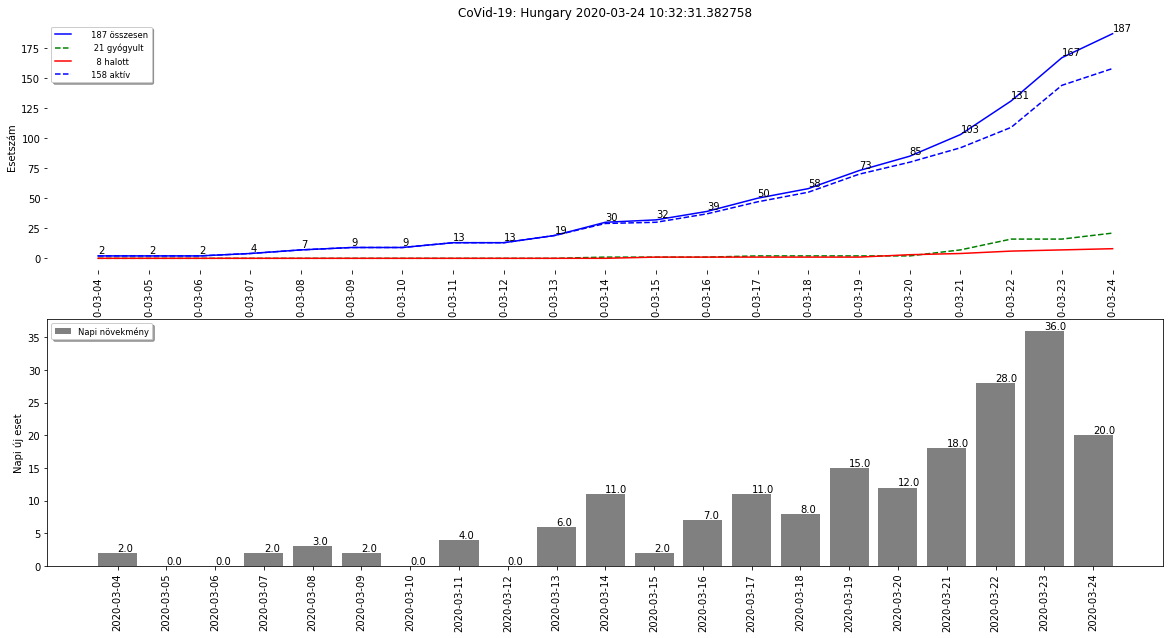

In [22]:
plt.figure(figsize=(20,10), tight_layout=False)
ax = plt.subplot(211, frameon=False)

plt.plot(df.index, df['Eset'], 'b-',     label=f"{df['Eset'].max():8} összesen")
plt.plot(df.index, df['Gyógyult'], 'g--', label=f"{df['Gyógyult'].max():8} gyógyult")
plt.plot(df.index, df['Halott'], 'r-',    label=f"{df['Halott'].max():8} halott")
plt.plot(df.index, df['Aktív'], 'b--',    label=f"{df['Aktív'].max():8} aktív")

for i,j in df.Eset.items():
    ax.annotate(str(j), xy=(i, j + 2))

plt.ylabel('Esetszám')
plt.title(f'CoVid-19: {the_country} {datetime.datetime.today()}')
plt.legend(shadow=True, fontsize='small')
plt.xticks(rotation='vertical')

bx = plt.subplot(212, frameon=True)
plt.bar(df.index, df['EsetD'], label='Napi növekmény', color='gray')
plt.ylabel('Napi új eset')
plt.xticks(rotation='vertical')
plt.legend(shadow=True, fontsize='small')

for i,j in df.EsetD.items():
     bx.annotate(j, xy=(i, j + .3))

plt.savefig(f'{the_country.lower()}.png')
# plt.show()
